# Decision Tree: Income Prediction
In this lab, we will build a decision tree to predict the income of a given population, which is labelled as <= 50k 𝑎𝑛𝑑 > 50k. The attributes (predictors) are age, working class type, marital status, gender, race etc.

In the following sections, we'll:

Clean and prepare the data,
- build a decision tree with default hyperparameters,
- understand all the hyperparameters that we can tune, and finally
- choose the optimal hyperparameters using grid search cross-validation.

In [1]:
!pip3 install -q matplotlib
!pip3 install -q scikit-learn

In [2]:
import os
import sys
os.environ["PYSPARK_PYTHON"] = "/usr/bin/python3"
os.environ["JAVA_HOME"] = "/usr/java/jdk-17.0.4/"
os.environ["SPARK_HOME"] = "/home/ec2-user/spark-3.3.0-bin-hadoop3"
os.environ["PYLIB"] = os.environ["SPARK_HOME"] + "/python/lib"
sys.path.insert(0, os.environ["PYLIB"] +"/py4j-0.10.9.5-src.zip")
sys.path.insert(0, os.environ["PYLIB"] +"/pyspark.zip")

In [3]:
# Importing the required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
# Reading the csv file and putting it into 'df' object.
df = pd.read_csv('adult_dataset.csv')

In [5]:
# Let's understand the data, how it look like.
df.head()

age workclass  fnlwgt     education  education.num marital.status  \
0   90         ?   77053       HS-grad              9        Widowed   
1   82   Private  132870       HS-grad              9        Widowed   
2   66         ?  186061  Some-college             10        Widowed   
3   54   Private  140359       7th-8th              4       Divorced   
4   41   Private  264663  Some-college             10      Separated   

          occupation   relationship   race     sex  capital.gain  \
0                  ?  Not-in-family  White  Female             0   
1    Exec-managerial  Not-in-family  White  Female             0   
2                  ?      Unmarried  Black  Female             0   
3  Machine-op-inspct      Unmarried  White  Female             0   
4     Prof-specialty      Own-child  White  Female             0   

   capital.loss  hours.per.week native.country income  
0          4356              40  United-States  <=50K  
1          4356              18  United-States  <=50K  
2          4356              40  United-States  <=50K  
3          3900              40  United-States  <=50K  
4          3900              40  United-States  <=50K

# NOTE
This dataset contains missing rows with a value='?'. Remove the missing values by dropping those rows.

In [6]:
# select all categorical variables
df_categorical = df.select_dtypes(include=['object'])

In [7]:
# checking whether any other columns contain a "?"
df_categorical.apply(lambda x: x=="?", axis=0).sum()

workclass         1836
education            0
marital.status       0
occupation        1843
relationship         0
race                 0
sex                  0
native.country     583
income               0
dtype: int64

In [8]:
# dropping the "?"s
df = df[df['workclass'] != '?']
df = df[df['occupation'] != '?']
df = df[df['native.country'] != '?']

In [9]:
# clean dataframe
df.head()

age workclass  fnlwgt     education  education.num marital.status  \
1   82   Private  132870       HS-grad              9        Widowed   
3   54   Private  140359       7th-8th              4       Divorced   
4   41   Private  264663  Some-college             10      Separated   
5   34   Private  216864       HS-grad              9       Divorced   
6   38   Private  150601          10th              6      Separated   

          occupation   relationship   race     sex  capital.gain  \
1    Exec-managerial  Not-in-family  White  Female             0   
3  Machine-op-inspct      Unmarried  White  Female             0   
4     Prof-specialty      Own-child  White  Female             0   
5      Other-service      Unmarried  White  Female             0   
6       Adm-clerical      Unmarried  White    Male             0   

   capital.loss  hours.per.week native.country income  
1          4356              18  United-States  <=50K  
3          3900              40  United-States  <=50K  
4          3900              40  United-States  <=50K  
5          3770              45  United-States  <=50K  
6          3770              40  United-States  <=50K

# Data Preparation
There are a number of preprocessing steps we need to do before building the model.

Firstly, note that we have both categorical and numeric features as predictors. In previous models such as linear and logistic regression, we had created dummy variables for categorical variables, since those models (being mathematical equations) can process only numeric variables.

All that is not required in decision trees, since they can process categorical variables easily. However, we still need to encode the categorical variables into a standard format so that sklearn can understand them and build the tree. We'll do that using the LabelEncoder() class, which comes with sklearn.preprocessing.

In [10]:
#import required libraries
from sklearn import preprocessing

In [11]:
# select all categorical variables from the clean dataframe
df_categorical = df.select_dtypes(include=['object'])

In [12]:
# apply Label encoder to df_categorical
le = preprocessing.LabelEncoder()
df_categorical = df_categorical.apply(le.fit_transform)

In [13]:
# concat df_categorical with original df
df = df.drop(df_categorical.columns, axis=1)
df = pd.concat([df, df_categorical], axis=1)

In [14]:
# convert target variable income to categorical
df['income'] = df['income'].astype('category')

Now all the categorical variables are suitably encoded. Let's build the model.

In [15]:
df.head()

age  fnlwgt  education.num  capital.gain  capital.loss  hours.per.week  \
1   82  132870              9             0          4356              18   
3   54  140359              4             0          3900              40   
4   41  264663             10             0          3900              40   
5   34  216864              9             0          3770              45   
6   38  150601              6             0          3770              40   

   workclass  education  marital.status  occupation  relationship  race  sex  \
1          2         11               6           3             1     4    0   
3          2          5               0           6             4     4    0   
4          2         15               5           9             3     4    0   
5          2         11               0           7             4     4    0   
6          2          0               5           0             4     4    1   

   native.country income  
1              38      0  
3              38      0  
4              38      0  
5              38      0  
6              38      0

# Model Building and Evaluation
Let's first build a decision tree with default hyperparameters. Then we'll use cross-validation to tune them.

In [16]:
df.columns

Index(['age', 'fnlwgt', 'education.num', 'capital.gain', 'capital.loss',
       'hours.per.week', 'workclass', 'education', 'marital.status',
       'occupation', 'relationship', 'race', 'sex', 'native.country',
       'income'],
      dtype='object')

In [17]:
# Importing train-test-split 
from sklearn.model_selection import train_test_split

In [18]:
# Putting feature variable to X
# Putting response variable to y
y = df["income"]
X = df.drop("income", axis=1)

In [19]:
print(f"y: {y.shape}")
print(f"X: {X.shape}")

y: (30162,)
X: (30162, 14)


In [20]:
# Splitting the data into train and test (70/30 ratio)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=27)

In [21]:
# Importing decision tree classifier from sklearn library
from sklearn.tree import DecisionTreeClassifier

In [22]:
# Build a Decision Tree
dt_basic = DecisionTreeClassifier(max_depth=10)

In [23]:
dt_basic.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=10)

In [24]:
# Let's check the evaluation metrics of our default model

In [25]:
# Importing classification report and confusion matrix from sklearn metrics
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn import metrics

In [26]:
# Making predictions
y_preds = dt_basic.predict(X_test)

In [27]:
# Printing classification report
print(classification_report(y_test, y_preds))

              precision    recall  f1-score   support

           0       0.87      0.94      0.90      6767
           1       0.76      0.57      0.65      2282

    accuracy                           0.85      9049
   macro avg       0.81      0.76      0.78      9049
weighted avg       0.84      0.85      0.84      9049



Question 1: Find the accuracy of the model. [Mark the correct answer in graded questions segment]

In [28]:
# Printing confusion matrix and accuracy
print(f"Confusion Matrix: \n{confusion_matrix(y_test, y_preds)}")

print(f"Accuracy: {metrics.accuracy_score(y_test, y_preds)}")

Confusion Matrix: 
[[6358  409]
 [ 976 1306]]
Accuracy: 0.8469444137473754


# Plotting the Decision Tree

To visualise decision trees in python, you need to install certain external libraries. You can read about the process in detail here: http://scikit-learn.org/stable/modules/tree.html

We need the ```graphviz``` library to plot a tree.

In [29]:
!pip3 install -q graphviz
!pip3 install -q pydotplus

In [30]:
# Importing required packages for visualization
from IPython.display import Image  
from six import StringIO  
from sklearn.tree import export_graphviz
import pydotplus, graphviz

In [31]:
# Putting features
features = list(X.columns)

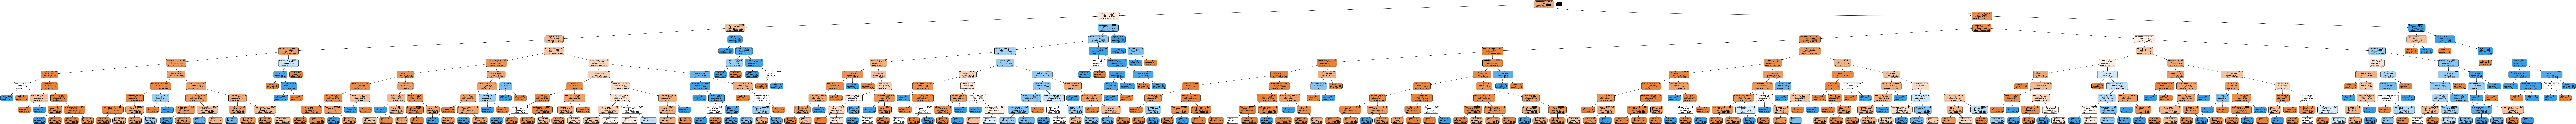

In [32]:
# Plot a Decision Tree
dot_data = StringIO()  
export_graphviz(dt_basic, 
                out_file=dot_data,
                feature_names=features, 
                filled=True, 
                rounded=True)

graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

# OPTIMAL HYPERPARAMETERS

In [33]:
#import libraries required
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV

Question 2: Which are the most optimal criteria for splitting? [Mark the correct answer in graded questions segment]

In [34]:
# Create the parameter grid 
param_grid = {"max_depth": range(5, 15, 5),
              "min_samples_leaf": range(50, 150, 50),
              "min_samples_split": range(50, 150, 50),
              "criterion": ["entropy", "gini"]}

n_folds = 5

In [35]:
dtree = DecisionTreeClassifier(random_state=27)

In [36]:
# Instantiate the grid search model
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV

grid = GridSearchCV(dtree,
                    param_grid,
                    cv=n_folds,
                    scoring="accuracy",
                    return_train_score=True)

In [37]:
# Fit the grid search to the data

grid.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=27),
             param_grid={'criterion': ['entropy', 'gini'],
                         'max_depth': range(5, 15, 5),
                         'min_samples_leaf': range(50, 150, 50),
                         'min_samples_split': range(50, 150, 50)},
             return_train_score=True, scoring='accuracy')

In [38]:
# printing the optimal accuracy score and hyperparameters
grid.best_params_

{'criterion': 'entropy',
 'max_depth': 10,
 'min_samples_leaf': 100,
 'min_samples_split': 50}

# Running the model with best parameters obtained from grid search.

In [39]:
# model with optimal hyperparameters
dtree_optimal = DecisionTreeClassifier(criterion="entropy", 
                                       max_depth=10, 
                                       min_samples_leaf=100, 
                                       min_samples_split=50)
dtree_optimal.fit(X_train, y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=10, min_samples_leaf=100,
                       min_samples_split=50)

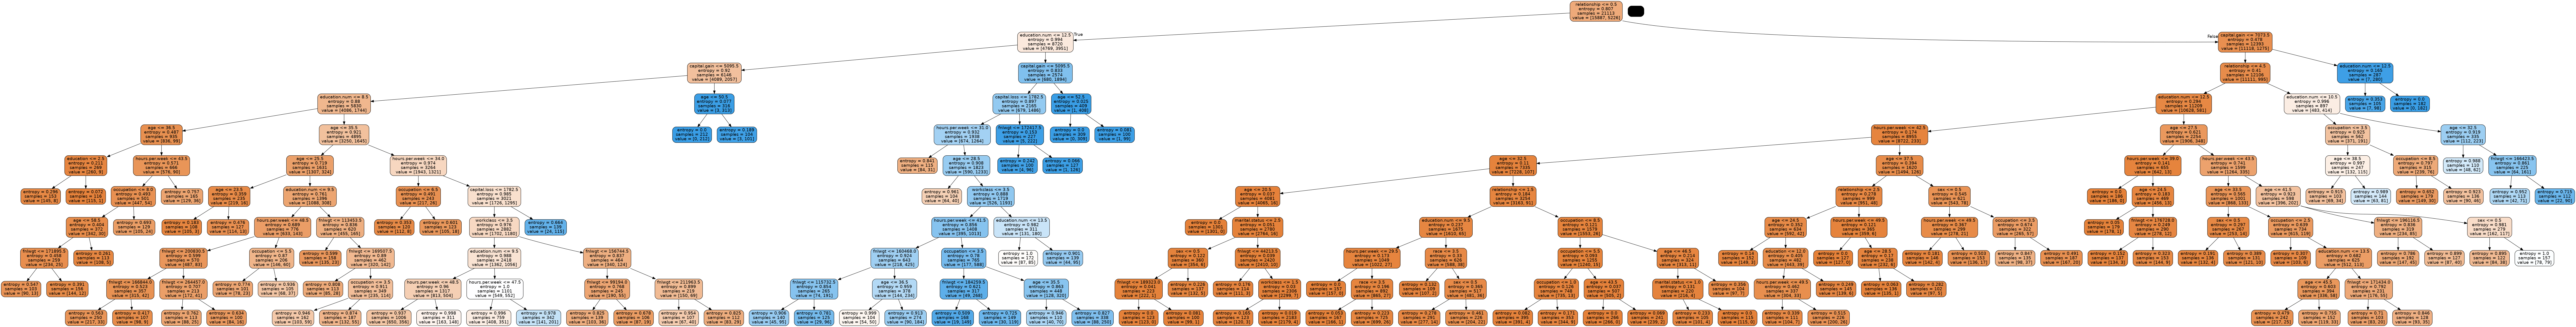

In [40]:
# Visualise the Tree
dot_data = StringIO()  
export_graphviz(decision_tree=dtree_optimal, 
                out_file=dot_data,
                feature_names=features, 
                filled=True,
                rounded=True)

graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

Question 3: What is the change in accuracy after using hyperparameters? [Mark the correct answer in graded questions segment]

In [41]:
y_preds_optimal = dtree_optimal.predict(X_test)

In [42]:
# accuracy score
print(classification_report(y_test, y_preds_optimal))
print(f"Accuracy: {dtree_optimal.score(X_test, y_test)}")

              precision    recall  f1-score   support

           0       0.86      0.94      0.90      6767
           1       0.75      0.55      0.64      2282

    accuracy                           0.84      9049
   macro avg       0.81      0.74      0.77      9049
weighted avg       0.83      0.84      0.83      9049

Accuracy: 0.8407558846281357


Text(0.5, 1.0, 'After Hyperparameter Tuning')

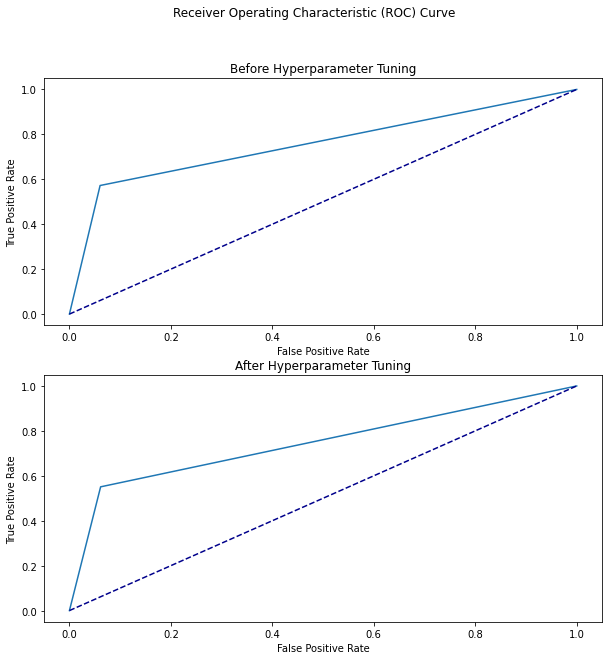

In [43]:
# plotting the tree
import matplotlib.pyplot as plt  
import sklearn.metrics as metrics

# Define false and true positive rate as follows:
plt.rcParams["figure.figsize"] = (10,10)
fig, axs = plt.subplots(2)
fig.suptitle('Receiver Operating Characteristic (ROC) Curve')
# fig.figure.siz

# Plot the ROC curve:
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_preds)
axs[0].plot(fpr, tpr)
axs[0].plot([0, 1], [0, 1], color='darkblue', linestyle='--')
axs[0].set_xlabel('False Positive Rate')
axs[0].set_ylabel('True Positive Rate')
axs[0].set_title('Before Hyperparameter Tuning')

fpr, tpr, thresholds = metrics.roc_curve(y_test, y_preds_optimal)
axs[1].plot(fpr, tpr)
axs[1].plot([0, 1], [0, 1], color='darkblue', linestyle='--')
axs[1].set_xlabel('False Positive Rate')
axs[1].set_ylabel('True Positive Rate')
axs[1].set_title('After Hyperparameter Tuning')